# 87 Rb F=2 Peak Blocked and Unblocked
## from A0012 and A0010

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
CalM_err = 1.8472146461547026e-06

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

def GausOnLine(x, a, b, amp, ctr, wid):
    return a * x + b + amp * np.exp( -((x - ctr)/wid)**2)

## Blocked Data

2.429537649695865
0.0077153074518917205


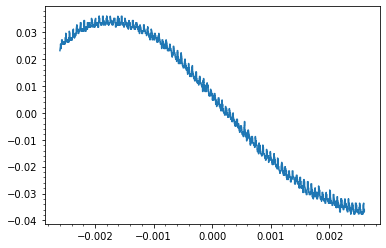

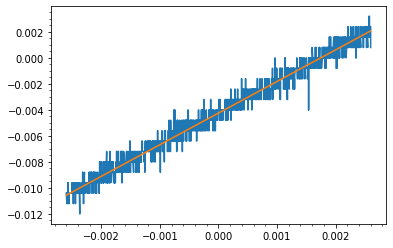

In [5]:
data =  pd.read_csv("A0012CH1 - Copy.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("A0012CH2 - Copy.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

t_start = -0.0026
t_end = 0.0026

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0012496990650513818
[-2.44663163e+01  6.22202517e-03]


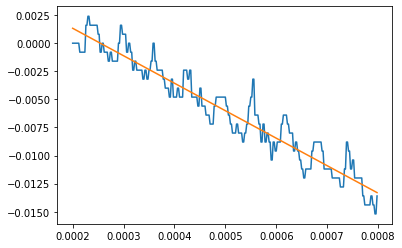

In [6]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == 0.0002:
        t1 = j
    if i == 0.0008:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

Reduced Chi Squared = 0.9025546771887262


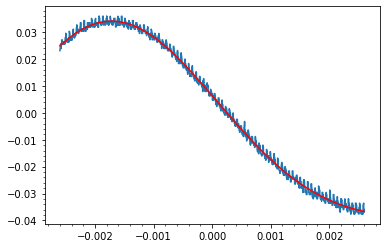

Reduced Chi Squared = 0.9049977872981503


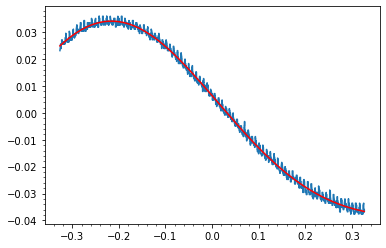

In [7]:
# Fit curve, apply Calibration, fit again
# GausOnLine(x, a, b, amp, ctr, wid)

guess = [-21, -0.019, 0.04, -0.0008, 0.003]

popt, pcov = optimize.curve_fit(GausOnLine, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
fit = GausOnLine(x, *popt)

#print("87Rb F=1 Peak Position: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
RCS = RdChiSqrd(y, GausOnLine(x, *popt), V_error, 5)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


# Calibration
#Calx = (-1)*Cali(x, popt[3], RampSlope)
Calx = (-1)*Cali(x, 0.0, RampSlope)

Cguess = [-21, -0.019, 0.04, -0.0008, 0.003]

popt, pcov = optimize.curve_fit(GausOnLine, Calx, y, p0=Cguess, maxfev=150000)
fit = GausOnLine(Calx, *popt)
RCS = RdChiSqrd(y, GausOnLine(Calx, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

#print("87Rb F=2 Seperation: " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0,0])) )
#print("87Rb F=2 FWHM: " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2,2])) )
#print("85Rb F=3 Seperation: " + str(popt[3]) + " +/- " + str(np.sqrt(pcov[3,3])) )
#print("85Rb F=3 FWHM: " + str(popt[5]) + " +/- " + str(np.sqrt(pcov[5,5])) )
#print("85Rb F=2 Seperation: " + str(popt[6]) + " +/- " + str(np.sqrt(pcov[6,6])) )
#print("85Rb F=2 FWHM: " + str(popt[8]) + " +/- " + str(np.sqrt(pcov[8,8])) )
#print("87Rb F=1 Seperation: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
#print("87Rb F=1 FWHM: " + str(popt[11]) + " +/- " + str(np.sqrt(pcov[11,11])) )

In [9]:
Blx = x
Bly = y
BlCalx = Calx

## Blocked Data

2.3897291647128696
0.007576474990816942


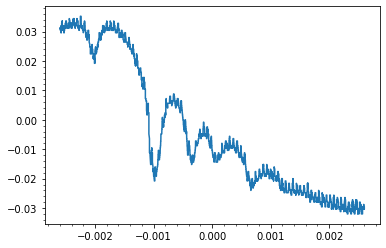

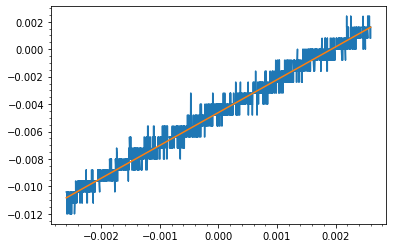

In [10]:
data =  pd.read_csv("A0010CH1 - Copy.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("A0010CH2 - Copy.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

t_start = -0.0026
t_end = 0.0026

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0013992658031294904
[-6.71763735 -0.01460457]


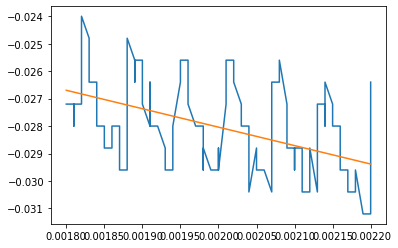

In [12]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == 0.0018:
        t1 = j
    if i == 0.0022:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [40,0.085]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

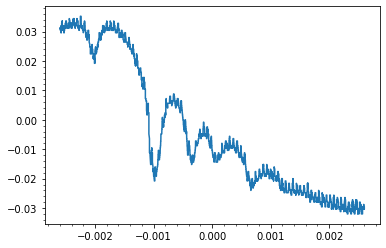

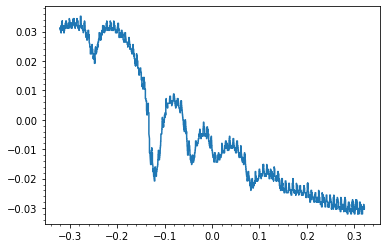

In [13]:
# Fit curve, apply Calibration, fit again
# GausOnLine(x, a, b, amp, ctr, wid)

#guess = [-21, -0.019, 0.04, -0.0008, 0.003]
#popt, pcov = optimize.curve_fit(GausOnLine, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
#fit = GausOnLine(x, *popt)

#print("87Rb F=1 Peak Position: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
#RCS = RdChiSqrd(y, GausOnLine(x, *popt), V_error, 5)
#print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
#plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

# Calibration
Calx = (-1)*Cali(x, 0.0, RampSlope)

#Cguess = [-21, -0.019, 0.04, -0.0008, 0.003]
#popt, pcov = optimize.curve_fit(GausOnLine, Calx, y, p0=Cguess, maxfev=150000)
#fit = GausOnLine(Calx, *popt)
#RCS = RdChiSqrd(y, GausOnLine(Calx, *popt), V_error, 12)
#print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
#plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

#print("87Rb F=2 Seperation: " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0,0])) )
#print("87Rb F=2 FWHM: " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2,2])) )
#print("85Rb F=3 Seperation: " + str(popt[3]) + " +/- " + str(np.sqrt(pcov[3,3])) )
#print("85Rb F=3 FWHM: " + str(popt[5]) + " +/- " + str(np.sqrt(pcov[5,5])) )
#print("85Rb F=2 Seperation: " + str(popt[6]) + " +/- " + str(np.sqrt(pcov[6,6])) )
#print("85Rb F=2 FWHM: " + str(popt[8]) + " +/- " + str(np.sqrt(pcov[8,8])) )
#print("87Rb F=1 Seperation: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
#print("87Rb F=1 FWHM: " + str(popt[11]) + " +/- " + str(np.sqrt(pcov[11,11])) )

In [15]:
UnBlx = x
UnBly = y
UnBlCalx = Calx

# Putting them together

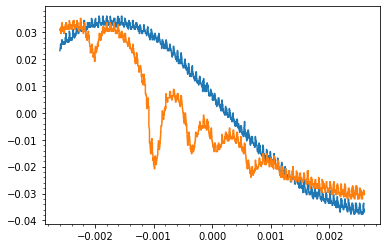

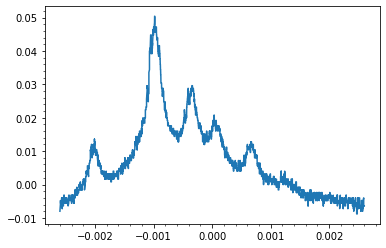

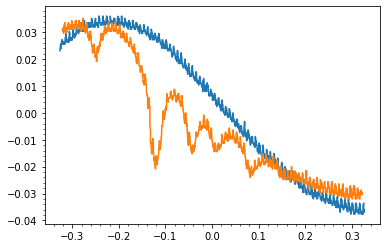

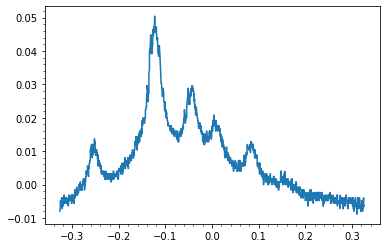

In [16]:
# Uncalibrated togther
plt.plot(Blx, Bly)
plt.plot(UnBlx, UnBly)
plt.minorticks_on()
plt.show()

# Uncalibrated difference
plt.plot((Blx) , (Bly-UnBly))
plt.minorticks_on()
plt.show()

# Calibrated togther
plt.plot(BlCalx, Bly)
plt.plot(UnBlCalx, UnBly)
plt.minorticks_on()
plt.show()

# Calibrated difference
plt.plot( BlCalx , (Bly-UnBly) )
plt.minorticks_on()
plt.show()